# Plot and compare tidal magnetic fields for different constituents

Created by A. Grayver, 2019, updated 2024

This notebook calculates magnetic fields due to different tidal constituents based on their Spherical Harmonic expansion coefficients. This notebook supplements the following publications:

- Grayver, A., Finlay, C. C., & Olsen, N. (2024). Magnetic signals from oceanic tides: new sat-ellite observations and applications. Philosophical Transactions of the Royal Society of London, doi: 10.1098/rsta.2024.0078. Preprint https://arxiv.org/abs/2404.03504
- Grayver, A. V., & Olsen, N. (2019). "The Magnetic Signatures of the M2, N2, and O1 Oceanic Tides Observed in Swarm and CHAMP Satellite Magnetic Data". *Geophysical Research Letters,* 46(8), 4230-4238. https://doi.org/10.1029/2019GL082400

If you use these models and data, please refer to these papers. 

**The script below uses results from other models, as described and referenced in the papers above**

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import chaosmagpy.model_utils as cpm

import cartopy.crs as ccrs
import cartopy.feature as cf

from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

%matplotlib inline

Put some global definitions to be used below

In [19]:
delta = 1.
theta = np.arange(delta / 2., 180., step = delta)
phi = np.arange(-180 + delta / 2., 180., step = delta)

theta_edge = np.arange(0., 180. + delta / 2, step = delta)
phi_edge = np.arange(-180, 180. + delta / 2., step = delta)

a = 6371.2
h = 430.
radius = a + h

constituents = ["M2", "N2", "O1", "Q1"]
constituents_latex = ["$M_2$", "$N_2$", "$O_1$", "$Q_1$"]

periods = [12.42060122,12.65834751,25.81933871,26.868350]

# Phase shift to the Greenwich meridian
# This needs to be applied to CM6 and KALMAG to compare with other models
pshift = {"M2": 35.719940, "N2": 356.002817, "O1": 25.507260, "Q1": 345.790138}

# Sabaka et al. 2020 reports these to be used as reliable Nmax
CM6_nmax = {"M2": 28, "N2": 12, "O1": 12}

model_names = ["GFO24", "GFO24-HR", "GO19", "CI9", "CM6", "KALMAG"]

B_range = [2., 0.5, 0.5, 0.1] # nT

Some auxiliary functions:

In [20]:
def read_MTI(file_name):
    lines = list()
    for line in open(file_name, "r"):
        if not line.strip().startswith("#"):
            lines.append(line.strip())
        
    nmax = int(lines[0].split()[0])
    period = float(lines[0].split()[1])
    lines = lines[1:]

    coeffs = np.zeros(shape=(nmax*(nmax+2), 2))
    idx = 0
    for line in lines:
        coeffs[idx,0] = float(line.split()[2])
        coeffs[idx,1] = float(line.split()[3])
        idx = idx + 1
        
    return coeffs,nmax,period

def read_KALMAG(file_name):

    nmax = 30

    lines = list()
    for line in open(file_name, "r"):
        if not line.strip().startswith("#"):
            lines.append(line.strip())
        
    coeffs = np.zeros(shape=(nmax*(nmax+2), 2))
    idx = 0
    for line in lines:
        coeffs[idx,0] = float(line.split()[2])
        coeffs[idx,1] = float(line.split()[3])
        idx = idx + 1
        
    return coeffs,nmax

def shift_phase(coeff, pshift = 0):

    pshift_rad = np.radians(pshift)
    
    R = np.array([[ np.cos(pshift_rad), np.sin(pshift_rad)], 
                  [-np.sin(pshift_rad), np.cos(pshift_rad)]])

    coeff_rotated = coeff @ R

    return coeff_rotated
    
def calculate_RMSD(B_mod, B_obs, dS):

    dB = B_obs - B_mod
    
    Im_RMSD  = np.sqrt( np.sum( ( np.imag(dB)**2. * dS ) ) / np.sum(dS) )
    Re_RMSD  = np.sqrt( np.sum( ( np.real(dB)**2. * dS ) / np.sum(dS) ) )
    Abs_RMSD = np.sqrt( np.sum( ( dB * np.conj(dB) * dS ) / np.sum(dS) ) )

    return Re_RMSD, Im_RMSD, Abs_RMSD

def calculate_RMSD_Abs(B_mod, B_obs, dS):

    dB = np.absolute(B_obs) - np.absolute(B_mod)

    Abs_RMSD = np.sqrt( np.sum( ( dB * dB * dS ) / np.sum(dS) ) )

    return Abs_RMSD

def calculate_Br_on_grid(tau, delta, theta, phi, radius, nmax):

    Br_re, _, _ = cpm.synth_values(tau[:,0], radius, theta, phi, nmax=nmax, source='internal', grid=True)
    Br_im, _, _ = cpm.synth_values(tau[:,1], radius, theta, phi, nmax=nmax, source='internal', grid=True)

    Br = Br_re + 1j * Br_im
    
    dS = np.sin(np.tile(np.deg2rad(theta), [1, len(phi)])) * np.deg2rad(delta) * np.deg2rad(delta) / (4*np.pi)

    return Br, dS

def powerspec(tau, h, a, nmax):
    
    R_n = np.zeros((nmax,))  
    aor = a / (a + h)
    faor = aor ** 2

    k = 0
    for n in range(1, nmax + 1):
        faor *= aor
        for m in range(n + 1):
            R_n[n - 1] += tau[k, 0] ** 2 + tau[k, 1] ** 2
            k += 1
            if m > 0:
                R_n[n - 1] += tau[k, 0] ** 2 + tau[k, 1] ** 2
                k += 1
        R_n[n - 1] = 0.5 * (n + 1) * R_n[n - 1] * faor ** 2

    return R_n

def plot_magnetic_maps(theta_grid, phi_grid, vmin, vmax, titles, *args, cbar_mode='single', cmap = 'PuOr_r', cbar_pad = 0.2, axes_pad=0.25, cbar_label=None):

    projection = ccrs.Mollweide()
    axes_class = (GeoAxes,
                  dict(projection=projection))

    fig = plt.figure()
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(2, 2),
                    axes_pad=axes_pad,
                    cbar_location='right',
                    cbar_mode=cbar_mode,
                    cbar_pad=cbar_pad,
                    cbar_size='3%',
                    label_mode='keep')  # note the empty label_mode

    # make subplots
    for i, ax in enumerate(axgr):
        
        ax.xaxis.set_ticks(np.linspace(-180., 180., num=13))
        ax.yaxis.set_ticks(np.linspace(-60., 60., num=5))
        ax.xaxis.set_major_formatter('')
        ax.grid(True)
        
        # produce colormesh and evaluate keywords (defaults and input)
        pc = ax.pcolormesh(phi_grid, 90. - theta_grid,
                           args[i], cmap = cmap, vmin = vmin, 
                           vmax = vmax, transform=ccrs.PlateCarree())

        ax.add_feature(cf.COASTLINE, linewidth=0.25)
        ax.set_title(titles[i])

        if cbar_mode == 'each':
            axgr.cbar_axes[i].colorbar(pc, extend='both', label=cbar_label)

    if cbar_mode == 'single':
        axgr.cbar_axes[0].colorbar(pc, extend='both', label=cbar_label)
    #fig.tight_layout()

    return fig, axgr

# Plot observed and simulated fields due to different tidal constutuents

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_208675/1991580217.py:9: SyntaxWarning: invalid escape sequence '\m'
  titles = ('$\mathcal{R}\{B_r^{obs}\}$', '$\mathcal{I}\{B_r^{obs}\}$', '$\mathcal{R}\{B_r^{DNS}\}$', '$\mathcal{I}\{B_r^{DNS}\}$')
/tmp/ipykernel_208675/1991580217.py:9: SyntaxWarning: invalid escape sequence '\m'
  titles = ('$\mathcal{R}\{B_r^{obs}\}$', '$\mathcal{I}\{B_r^{obs}\}$', '$\mathcal{R}\{B_r^{DNS}\}$', '$\mathcal{I}\{B_r^{DNS}\}$')
/tmp/ipykernel_208675/1991580217.py:9: SyntaxWarning: invalid escape sequence '\m'
  titles = ('$\mathcal{R}\{B_r^{obs}\}$', '$\mathcal{I}\{B_r^{obs}\}$', '$\mathcal{R}\{

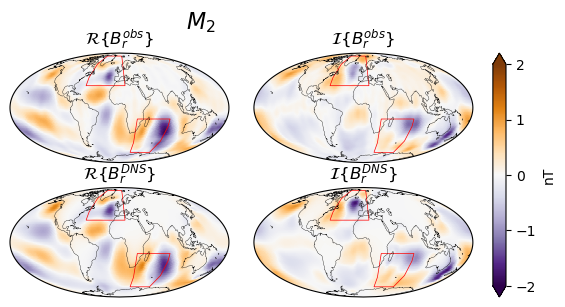

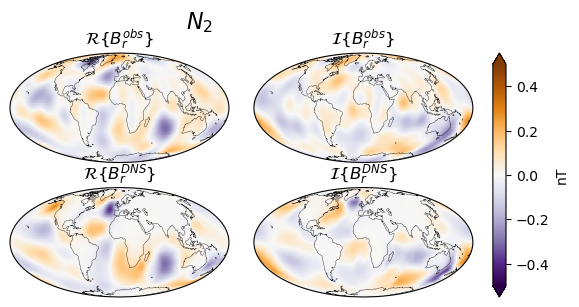

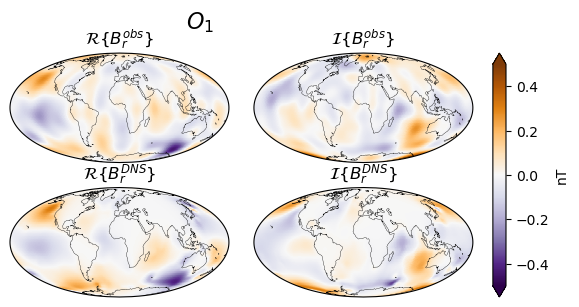

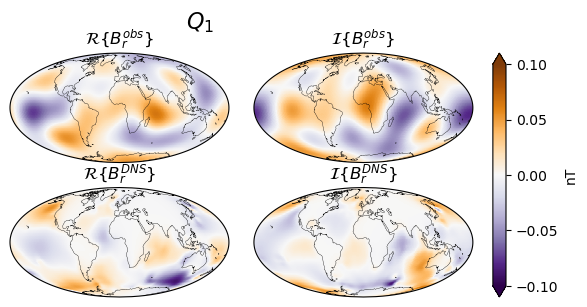

In [21]:
GFO24_path = "./data/GFO24-HR/"
for i in range(len(constituents)):
    coeffs,nmax,period = read_MTI(GFO24_path + constituents[i] + ".txt")
    
    Br_obs, dS = calculate_Br_on_grid(coeffs, delta, theta, phi, radius, nmax)

    Br_mod = np.roll(np.load("./data/MODEL/%s_Br_mod_430km.npz" % constituents[i])['Br_model'], 180, axis=1)

    titles = ('$\mathcal{R}\{B_r^{obs}\}$', '$\mathcal{I}\{B_r^{obs}\}$', '$\mathcal{R}\{B_r^{DNS}\}$', '$\mathcal{I}\{B_r^{DNS}\}$')
    fig, axes = plot_magnetic_maps(theta, phi, -B_range[i], B_range[i], titles, np.real(Br_obs), np.imag(Br_obs), np.real(Br_mod), np.imag(Br_mod), cbar_pad = 0.2, axes_pad=0.25, cbar_label='nT')

    if constituents[i] == "M2":
        for ax in axes:
            ax.add_patch(mpl.patches.Rectangle(xy=[-60, 30], width=70, height=50,
                         facecolor='none', edgecolor='r', lw=0.5, transform=ccrs.PlateCarree()))
            ax.add_patch(mpl.patches.Rectangle(xy=[30, -65], width=55, height=50,
                         facecolor='none', edgecolor='r', lw=0.5, transform=ccrs.PlateCarree()))
    
    fig.text(0.4, 0.8, constituents_latex[i], fontsize=16, fontweight='bold')
    plt.savefig(GFO24_path + constituents[i] + ".png", dpi=300, bbox_inches="tight")

#### Standard deviations

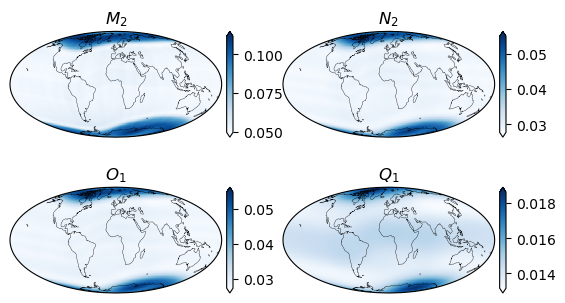

In [22]:
dB_CHAOS = 2 # average of standard deviations reported for the CHAOS-7 model for CHAMP and Swarm (see Figure 6 in 10.1186/s40623-020-01252-9)

# Rescale from nominal 1 nT data error to the CHAOS-7 based residual-based statistics
dBr_M2 = np.flipud(np.loadtxt("./data/GFO24-HR/stdev_M2.txt")) * dB_CHAOS
dBr_N2 = np.flipud(np.loadtxt("./data/GFO24-HR/stdev_N2.txt")) * dB_CHAOS
dBr_O1 = np.flipud(np.loadtxt("./data/GFO24-HR/stdev_O1.txt")) * dB_CHAOS
dBr_Q1 = np.flipud(np.loadtxt("./data/GFO24-HR/stdev_Q1.txt")) * dB_CHAOS

fig, axes = plot_magnetic_maps(theta, phi, None, None, constituents_latex, dBr_M2, dBr_N2, dBr_O1, dBr_Q1, cbar_mode='each', cmap='Blues', cbar_pad=0.05, axes_pad=0.5, cbar_label=None)
plt.savefig("./data/GFO24-HR/stdev_all.png", dpi=300, bbox_inches="tight")

## Cross-comparison of different models

### Root-mean-square deviation

In [23]:
df_RMSD = pd.DataFrame(data=None, index=model_names, columns=constituents) # in nT

df_NMAX = pd.DataFrame(data=None, index=model_names, columns=constituents) # maximum SH degree

for c in constituents:
    Br_mod = np.roll(np.load("./data/MODEL/%s_Br_mod_430km.npz" % c)['Br_model'], 180, axis=1)
    
    for model in model_names:

        try:
            if model == "KALMAG":
                coeffs,nmax = read_KALMAG("./data/%s/TIDAL%s.dat" % (model, c))
            else:
                coeffs,nmax,period = read_MTI("./data/%s/%s.txt" % (model, c))

            if model == "CM6":
                nmax = CM6_nmax[c]

            if model in ["CM6", "KALMAG"]:
                coeffs = shift_phase(coeffs, pshift[c])
        except:
            continue
            
        Br, dS = calculate_Br_on_grid(coeffs, delta, theta, phi, radius, nmax)

        #Abs_RMSD = calculate_RMSD_Abs(Br_mod.flatten('F'), Br.flatten('F'), dS)
        Re_RMSD, Im_RMSD, Abs_RMSD = calculate_RMSD(Br_mod.flatten('F'), Br.flatten('F'), dS)
        
        df_RMSD.loc[model, c] = np.real(Abs_RMSD)

        df_NMAX.loc[model, c] = nmax

print(df_RMSD, "\n")
print(df_NMAX, "\n")

print(df_RMSD.to_latex())
print(df_NMAX.to_latex())

                M2        N2        O1        Q1
GFO24     0.166052  0.063506   0.07043   0.02705
GFO24-HR   0.16664  0.068695  0.073804  0.033482
GO19      0.193449  0.088034  0.098215       NaN
CI9       0.169479       NaN       NaN       NaN
CM6       0.196237  0.088885  0.125614       NaN
KALMAG    0.210778  0.088329  0.092135  0.061918 

          M2   N2   O1   Q1
GFO24     28   12   12    4
GFO24-HR  32   14   14    6
GO19      28   12   12  NaN
CI9       18  NaN  NaN  NaN
CM6       28   12   12  NaN
KALMAG    30   30   30   30 

\begin{tabular}{lllll}
\toprule
 & M2 & N2 & O1 & Q1 \\
\midrule
GFO24 & 0.166052 & 0.063506 & 0.070430 & 0.027050 \\
GFO24-HR & 0.166640 & 0.068695 & 0.073804 & 0.033482 \\
GO19 & 0.193449 & 0.088034 & 0.098215 & NaN \\
CI9 & 0.169479 & NaN & NaN & NaN \\
CM6 & 0.196237 & 0.088885 & 0.125614 & NaN \\
KALMAG & 0.210778 & 0.088329 & 0.092135 & 0.061918 \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
 & M2 & N2 & O1 & Q1 \\
\midrule
GFO24 & 

### Cross-correlation

In [24]:
models_per_tide = {"M2": ["GFO24", "GFO24-HR", "GO19", "CI9", "CM6", "KALMAG"], 
                   "N2": ["GFO24", "GFO24-HR", "GO19", "CM6", "KALMAG"],
                   "O1": ["GFO24", "GFO24-HR", "GO19", "CM6", "KALMAG"],
                   "Q1": ["GFO24", "GFO24-HR", "KALMAG"]}

sim_name = "DNS"

# Code to create correlation plots between absolute Br values
for i, c in enumerate(constituents):

    Br_mod = np.roll(np.load("./data/MODEL/%s_Br_mod_430km.npz" % c)['Br_model'], 180, axis=1).flatten()
    
    mnames = models_per_tide[c] + [sim_name,]

    Br_Abs = pd.DataFrame(data=np.zeros((len(Br_mod),len(mnames))), columns=mnames)
    Br_Re = pd.DataFrame(data=np.zeros((len(Br_mod),len(mnames))), columns=mnames)
    Br_Im = pd.DataFrame(data=np.zeros((len(Br_mod),len(mnames))), columns=mnames)

    Br_Abs["DNS"] = np.absolute(Br_mod)
    Br_Re["DNS"] = np.real(Br_mod)
    Br_Im["DNS"] = np.imag(Br_mod)
    
    for model in mnames[:-1]:
        if model == "KALMAG":
            coeffs,nmax = read_KALMAG("./data/%s/TIDAL%s.dat" % (model, c))
        else:
            coeffs,nmax,period = read_MTI("./data/%s/%s.txt" % (model, c))

        if model == "CM6":
            nmax = CM6_nmax[c]

        if model in ["CM6", "KALMAG"]:
            coeffs = shift_phase(coeffs, pshift[c])

        Br_obs, _ = calculate_Br_on_grid(coeffs, delta, theta, phi, radius, nmax)

        Br_Abs[model] = np.absolute(Br_obs.flatten())
        Br_Re[model] = np.real(Br_obs.flatten())
        Br_Im[model] = np.imag(Br_obs.flatten())

    print(c + ' Re\n', Br_Re.corr(), "\n")
    print(c + ' Im\n', Br_Im.corr(), "\n")
    print(c + ' Abs\n', Br_Abs.corr(), "\n")

    ax = sns.heatmap(
        Br_Re.corr(), 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot=True,
        cbar=False
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0
    )
    ax.set_title(constituents_latex[i])

    plt.savefig("./figures/" + c + "_cross_correlation.pdf", bbox_inches="tight")
    plt.savefig("./figures/" + c + "_cross_correlation.png", dpi=300, bbox_inches="tight")
    plt.close()

M2 Re
              GFO24  GFO24-HR      GO19       CI9       CM6    KALMAG       DNS
GFO24     1.000000  0.997880  0.953294  0.931750  0.955484  0.885676  0.943297
GFO24-HR  0.997880  1.000000  0.951259  0.930253  0.954051  0.884130  0.942683
GO19      0.953294  0.951259  1.000000  0.891822  0.934673  0.868546  0.906768
CI9       0.931750  0.930253  0.891822  1.000000  0.934218  0.895996  0.940563
CM6       0.955484  0.954051  0.934673  0.934218  1.000000  0.899296  0.950632
KALMAG    0.885676  0.884130  0.868546  0.895996  0.899296  1.000000  0.918676
DNS       0.943297  0.942683  0.906768  0.940563  0.950632  0.918676  1.000000 

M2 Im
              GFO24  GFO24-HR      GO19       CI9       CM6    KALMAG       DNS
GFO24     1.000000  0.997482  0.934700  0.855682  0.882967  0.808205  0.858765
GFO24-HR  0.997482  1.000000  0.931520  0.852126  0.882410  0.805197  0.857411
GO19      0.934700  0.931520  1.000000  0.846609  0.853174  0.822273  0.864345
CI9       0.855682  0.852126  0.8466

### Comparison of spectra

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


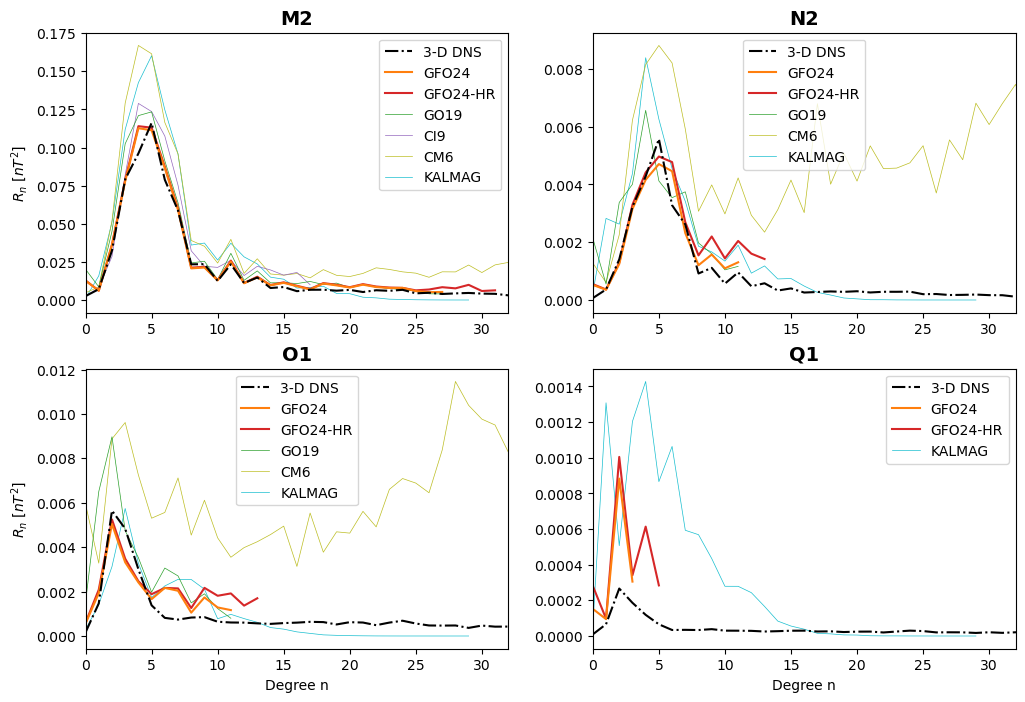

In [25]:
colors = {"GFO24": "tab:orange", "GFO24-HR": "tab:red", "GO19": "tab:green", "CI9": "tab:purple", "CM6": "tab:olive", "KALMAG": "tab:cyan"}

fig, ax = plt.subplots(2,2,figsize=(12,8))

idxs = {"M2": [0, 0], "N2": [0, 1], "O1": [1, 0], "Q1": [1, 1]}

thin_lines = ["GO19", "CI9", "CM6", "KALMAG"]

for c in constituents:

    i=idxs[c]

    R_n_mod = np.load("./data/MODEL/%s_Br_mod_430km.npz" % c)['R_n']

    for model in reversed(models_per_tide[c]):

        if model == "KALMAG":
            coeffs,nmax = read_KALMAG("./data/%s/TIDAL%s.dat" % (model, c))
        else:
            coeffs,nmax,period = read_MTI("./data/%s/%s.txt" % (model, c))

        R = powerspec(tau = coeffs, h = 0, a = a, nmax = nmax)

        if model in thin_lines:
            ax[i[0],i[1]].plot(R, label=model, color=colors[model], linewidth=0.5)
        else:
            ax[i[0],i[1]].plot(R, label=model, color=colors[model], linewidth=1.5)

    ax[i[0],i[1]].plot(R_n_mod, label="3-D DNS", color='k', linestyle='-.')
    
    ax[i[0],i[1]].set_xlim([0, 32])
    ax[i[0],i[1]].set_title(c, fontsize=14, fontweight='bold')
    ax[i[0],i[1]].legend()

    handles,labels = ax[i[0],i[1]].get_legend_handles_labels()
    ax[i[0],i[1]].legend(reversed(handles),reversed(labels))

ax[1,0].set_xlabel('Degree n')
ax[1,1].set_xlabel('Degree n')

ax[0,0].set_ylabel('$R_n$ [$nT^2$]')
ax[1,0].set_ylabel('$R_n$ [$nT^2$]')

plt.savefig("./figures/SH_spectra.eps", bbox_inches="tight")
plt.savefig("./figures/SH_spectra.png", dpi=300, bbox_inches="tight")